In [6]:
!pip install transformers datasets rouge-score accelerate bitsandbytes

## Environment & Setup —— Baseline Model

#### 1. Use baseline Model(FP32 baseline)

In [10]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

### init model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(device)

print("Model loaded (FP32 baseline).")

Using device: cuda
Model loaded (FP32 baseline).


#### 2. Load Dataset

In [11]:
from datasets import load_dataset

### Load dataset
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")

train_data = dataset["train"]
val_data   = dataset["validation"]
test_data  = dataset["test"]

train_data.to_csv("train.csv")
val_data.to_csv("val.csv")
test_data.to_csv("test.csv")

print("Dataset loaded:")
print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Creating CSV from Arrow format:   0%|          | 0/288 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Dataset loaded:
Train: 287113
Validation: 13368
Test: 11490


#### 3.⭐⭐⭐ Summarization Pipeline(重点研究)-(single request)

In [12]:
MAX_SUMMARY_LEN = 128
NUM_BEAMS = 4
WARMUP_ITERATIONS = 2

def summarize_batch(texts, model, tokenizer, max_len=MAX_SUMMARY_LEN, num_beams=NUM_BEAMS):
    """
    Single-request summarization using model.generate.
    Returns a decoded string summary.
    """
    # 统一输入格式
    if isinstance(texts, str):
        texts = [texts]
        return_single = True
    else:
        return_single = False

    inputs = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        max_length=1024,
        padding=True  # 为批处理做准备
    ).to(device)

    with torch.no_grad():
        out_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs.get("attention_mask", None),
            num_beams=num_beams,
            max_length=max_len,
            early_stopping=True
        )
    summaries = [tokenizer.decode(ids, skip_special_tokens=True) for ids in out_ids]

    return summaries[0] if return_single else summaries

# 为保持接口一致性，可以保留 summarize 作为别名
summarize = summarize_batch


#### 4. Build （Latency / Throughput / ROUGE） Tools

##### 4.1 ROUGE Scorer

In [13]:
from rouge_score import rouge_scorer

rouge = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)

def eval_rouge(pred, ref):
    score = rouge.score(ref, pred)
    return {k: v.fmeasure for k, v in score.items()}


##### 4.2 Latency

In [14]:
import time

def measure_latency(text, model, tokenizer, warmup=True):
    if warmup:
        # 热身运行，避免第一次推理的冷启动影响
        for _ in range(WARMUP_ITERATIONS):
            _ = summarize(text, model, tokenizer)

    # 正式测量
    start_time = time.perf_counter()  # 使用更高精度的计时器
    _ = summarize(text, model, tokenizer)
    end_time = time.perf_counter()

    return end_time - start_time

##### 4.3 Throughput

In [15]:
def measure_throughput_sequential(texts, model, tokenizer):
    """
    顺序处理的吞吐量测量（作为对比参考）
    """
    # 热身
    _ = summarize(texts[0], model, tokenizer)

    start_time = time.perf_counter()
    for text in texts:
        _ = summarize(text, model, tokenizer)
    total_time = time.perf_counter() - start_time

    return len(texts) / total_time

4.4 Total evaluate

In [16]:
def evaluate_model_comprehensive(dataset, model, tokenizer, model_name="Unknown"):
    """
    Comprehensive evaluation function for model performance and quality

    Args:
        dataset: Test dataset
        model: Model instance
        tokenizer: Tokenizer instance
        model_name: Model identifier name

    Returns:
        Dictionary containing all evaluation metrics
    """
    print(f"\n🔍 Starting evaluation for model: {model_name}")

    results = []
    latencies = []
    texts = [item["article"] for item in dataset]

    # 1. Measure latency and generate summaries
    print("📊 Measuring latency and generating summaries...")
    for i, item in enumerate(dataset):
        if i % 10 == 0:
            print(f"   Progress: {i}/{len(dataset)}")

        latency = measure_latency(item["article"], model, tokenizer, warmup=(i==0))
        latencies.append(latency)

        pred = summarize(item["article"], model, tokenizer)
        results.append((pred, item["highlights"]))

    # 2. Calculate ROUGE scores
    print("📈 Calculating ROUGE scores...")
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}

    for pred, ref in results:
        score = eval_rouge(pred, ref)
        rouge_scores["rouge1"].append(score["rouge1"])
        rouge_scores["rouge2"].append(score["rouge2"])
        rouge_scores["rougeL"].append(score["rougeL"])

    # 3. Measure throughput with different batch sizes
    print("⚡ Measuring throughput...")
    throughput_sequential = measure_throughput_sequential(texts, model, tokenizer)

    # 4. Calculate statistical metrics
    import numpy as np
    avg_latency = np.mean(latencies)
    latency_std = np.std(latencies)

    # Build results dictionary
    evaluation_results = {
        "model_name": model_name,
        "performance_metrics": {
            "avg_latency_sec": round(avg_latency, 4),
            "latency_std": round(latency_std, 4),
            "throughput_sequential_req_per_sec": round(throughput_sequential, 4),
            "min_latency": round(np.min(latencies), 4),
            "max_latency": round(np.max(latencies), 4),
            "p95_latency": round(np.percentile(latencies, 95), 4)
        },
        "quality_metrics": {
            "rouge1": round(np.mean(rouge_scores["rouge1"]), 4),
            "rouge2": round(np.mean(rouge_scores["rouge2"]), 4),
            "rougeL": round(np.mean(rouge_scores["rougeL"]), 4),
            "rouge1_std": round(np.std(rouge_scores["rouge1"]), 4),
            "rouge2_std": round(np.std(rouge_scores["rouge2"]), 4),
            "rougeL_std": round(np.std(rouge_scores["rougeL"]), 4)
        },
        "test_config": {
            "sample_size": len(dataset),
            "max_summary_length": MAX_SUMMARY_LEN,
            "num_beams": NUM_BEAMS,
            "device": str(device)
        }
    }

    print(f"✅ Evaluation completed for {model_name}")
    return evaluation_results

#### Test: Prepare small test set

In [25]:
SAMPLE_NUM = 20
def get_samples(ds, n=SAMPLE_NUM):
    n = min(n, len(ds))
    return ds.select(range(n))

In [26]:
small_test = get_samples(test_data, SAMPLE_NUM)
print(f"[INFO] Using {len(small_test)} samples for baseline evaluation.")

[INFO] Using 20 samples for baseline evaluation.


#### 🌟🌟🌟 5.Bulid BaseLine

In [27]:
# baseLine
def run_baseline(dataset, model, tokenizer):
    results = []
    for item in dataset:
        article = item["article"]
        ref = item["highlights"]
        pred = summarize(article, model, tokenizer)
        results.append((pred, ref))
    return results

In [28]:
baseline_results = run_baseline(small_test, model, tokenizer)
print("Baseline inference finished.")

Baseline inference finished.


In [29]:
def evaluate_rouge_dataset(results):
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
    for pred, ref in results:
        score = eval_rouge(pred, ref)
        rouge1_scores.append(score["rouge1"])
        rouge2_scores.append(score["rouge2"])
        rougeL_scores.append(score["rougeL"])

    return {
        "ROUGE-1": sum(rouge1_scores)/len(rouge1_scores),
        "ROUGE-2": sum(rouge2_scores)/len(rouge2_scores),
        "ROUGE-L": sum(rougeL_scores)/len(rougeL_scores),
    }

baseline_rouge = evaluate_rouge_dataset(baseline_results)
baseline_rouge

{'ROUGE-1': 0.35022025793945055,
 'ROUGE-2': 0.1478972899837078,
 'ROUGE-L': 0.2604310393319945}

In [30]:
import numpy as np

latencies = [measure_latency(item["article"], model, tokenizer) for item in small_test]
baseline_latency = np.mean(latencies)
baseline_latency

np.float64(1.1165089720999049)

In [31]:
texts = [item["article"] for item in small_test]
baseline_throughput = measure_throughput_sequential(texts, model, tokenizer)
baseline_throughput

0.893014765105986

##### 6. Build  Baseline Report

6.1 记录 Baseline 指标

平均延迟（sec/request）

吞吐量（req/sec）

ROUGE-1/2/L 基线

生成一份 baseline 报告（供优化对照）

In [32]:
# 6. Build Baseline Report
print("=== Generating Baseline Report ===")

baseline_results = evaluate_model_comprehensive(
    dataset=small_test,
    model=model,
    tokenizer=tokenizer,
    model_name="BART-large-cnn FP32 Baseline"
)

print("\n" + "="*60)
print("6.1 BASELINE METRICS REPORT")
print("="*60)

print(f"📊 Average Latency: {baseline_results['performance_metrics']['avg_latency_sec']} sec/request")

print(f"⚡ Throughput (Sequential): {baseline_results['performance_metrics']['throughput_sequential_req_per_sec']} req/sec")

print(f"🎯 ROUGE-1: {baseline_results['quality_metrics']['rouge1']}")
print(f"🎯 ROUGE-2: {baseline_results['quality_metrics']['rouge2']}")
print(f"🎯 ROUGE-L: {baseline_results['quality_metrics']['rougeL']}")

print(f"📈 Latency Statistics:")
print(f"   - Std: {baseline_results['performance_metrics']['latency_std']} sec")
print(f"   - P95: {baseline_results['performance_metrics']['p95_latency']} sec")
print(f"   - Min-Max: {baseline_results['performance_metrics']['min_latency']}-{baseline_results['performance_metrics']['max_latency']} sec")

print("="*60)
print("✅ Baseline report generated successfully!")

=== Generating Baseline Report ===

🔍 Starting evaluation for model: BART-large-cnn FP32 Baseline
📊 Measuring latency and generating summaries...
   Progress: 0/20
   Progress: 10/20
📈 Calculating ROUGE scores...
⚡ Measuring throughput...
✅ Evaluation completed for BART-large-cnn FP32 Baseline

6.1 BASELINE METRICS REPORT
📊 Average Latency: 1.119 sec/request
⚡ Throughput (Sequential): 0.8825 req/sec
🎯 ROUGE-1: 0.3502
🎯 ROUGE-2: 0.1479
🎯 ROUGE-L: 0.2604
📈 Latency Statistics:
   - Std: 0.2143 sec
   - P95: 1.4664 sec
   - Min-Max: 0.8487-1.5834 sec
✅ Baseline report generated successfully!


6.1.2 save to report

In [ ]:
import json
from datetime import datetime

# 保存基线结果到文件
def save_baseline_report(results, filename=None):
    if filename is None:
        filename = f"baseline_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

    report = {
        "report_type": "baseline",
        "generated_at": datetime.now().isoformat(),
        **results
    }

    with open(filename, 'w') as f:
        json.dump(report, f, indent=2)

    print(f"📄 Baseline report saved to: {filename}")
    return filename

# 保存基线报告
report_file = save_baseline_report(baseline_results)

6.2 记录模型在不同输入长度下的性能

文章长度 vs latency 曲线

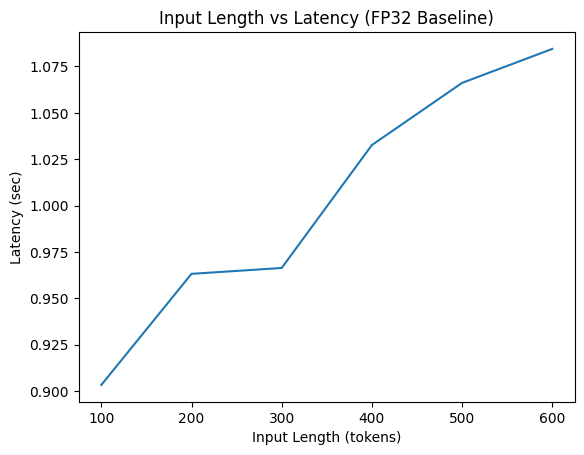

In [22]:
import matplotlib.pyplot as plt
import numpy as np

length_buckets = [100, 200, 300, 400, 500, 600]

def get_by_length(ds, target_len, tol=30):
    samples = []
    for item in ds:
        if abs(len(tokenizer(item["article"])["input_ids"]) - target_len) < tol:
            samples.append(item["article"])
        if len(samples) >= 5:
            break
    return samples

bucket_latency = {}

for L in length_buckets:
    texts = get_by_length(test_data, L)
    lat = [measure_latency(t, model, tokenizer) for t in texts]
    bucket_latency[L] = np.mean(lat)
plt.plot(list(bucket_latency.keys()), list(bucket_latency.values()))
plt.xlabel("Input Length (tokens)")
plt.ylabel("Latency (sec)")
plt.title("Input Length vs Latency (FP32 Baseline)")
plt.show()



## 7. Optimization Phase

执行 PTQ（Post-Training Quantization）

测试四种精度：

FP32（baseline）

FP16

INT8

INT4

### 7.1 get models

In [36]:
import torch
from transformers import BartForConditionalGeneration, BitsAndBytesConfig, is_bitsandbytes_available

def create_quantized_models(base_model_name="facebook/bart-large-cnn", device="cuda"):
    """
    创建优化后的不同精度版本 BART 模型，用于 GPU 推理。
    """
    print("🔄 Creating optimized quantized models...")
    models = {}

    # 检查 GPU
    if not torch.cuda.is_available():
        raise EnvironmentError("GPU not available. bitsandbytes INT8/INT4 requires GPU.")

    bnb_available = is_bitsandbytes_available(check_library_only=True)
    if not bnb_available:
        print("⚠️ bitsandbytes not available. INT8/INT4 models will be skipped.")

    # 1. FP32 baseline
    print("   Loading FP32 baseline...")
    models['fp32'] = BartForConditionalGeneration.from_pretrained(
        base_model_name,
        torch_dtype=torch.float32
    ).to(device)
    models['fp32'].eval()

    # 2. FP16 - 优化版本
    print("   Creating optimized FP16 model...")
    models['fp16'] = BartForConditionalGeneration.from_pretrained(
        base_model_name,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True  # 减少CPU内存使用
    ).to(device)
    models['fp16'].eval()

    # 3. INT8 (bitsandbytes) - 优化配置
    models['int8'] = None
    if bnb_available:
        try:
            print("   Creating optimized INT8 model...")
            bnb_config_8bit = BitsAndBytesConfig(
                load_in_8bit=True,
                llm_int8_enable_fp32_cpu_offload=True,  # 启用FP32 CPU卸载
                llm_int8_skip_modules=None,  # 不跳过任何模块
                llm_int8_threshold=6.0,      # 调整阈值
                llm_int8_has_fp16_weight=False
            )
            models['int8'] = BartForConditionalGeneration.from_pretrained(
                base_model_name,
                quantization_config=bnb_config_8bit,
                device_map="auto",
                torch_dtype=torch.float16
            )
            print("   ✅ INT8 model created successfully")
        except Exception as e:
            print(f"   ⚠️ INT8 creation failed: {e}")
            # 回退到简化配置
            try:
                print("   🔄 Trying simplified INT8 config...")
                bnb_config_simple = BitsAndBytesConfig(load_in_8bit=True)
                models['int8'] = BartForConditionalGeneration.from_pretrained(
                    base_model_name,
                    quantization_config=bnb_config_simple,
                    device_map="auto"
                )
                print("   ✅ INT8 model created with simple config")
            except Exception as e2:
                print(f"   ❌ INT8 failed completely: {e2}")

    # 4. INT4 (bitsandbytes) - 优化配置
    models['int4'] = None
    if bnb_available:
        try:
            print("   Creating optimized INT4 model...")
            bnb_config_4bit = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_use_double_quant=True,  # 启用双量化
                bnb_4bit_quant_storage=torch.uint8
            )
            models['int4'] = BartForConditionalGeneration.from_pretrained(
                base_model_name,
                quantization_config=bnb_config_4bit,
                device_map="auto",
                torch_dtype=torch.float16
            )
            print("   ✅ INT4 model created successfully")
        except Exception as e:
            print(f"   ⚠️ INT4 creation failed: {e}")
            # 回退到简化配置
            try:
                print("   🔄 Trying simplified INT4 config...")
                bnb_config_simple_4bit = BitsAndBytesConfig(load_in_4bit=True)
                models['int4'] = BartForConditionalGeneration.from_pretrained(
                    base_model_name,
                    quantization_config=bnb_config_simple_4bit,
                    device_map="auto"
                )
                print("   ✅ INT4 model created with simple config")
            except Exception as e2:
                print(f"   ❌ INT4 failed completely: {e2}")

    print("✅ All models loaded successfully!")
    return models

7.2 测试不同模型的结果

In [37]:
from datetime import datetime
# 简洁循环版本
print("=== Simplified Quantization Comparison ===")
models = create_quantized_models()

#  逐个测试其他量化模型并与基线对比
print("\n" + "="*80)
print("=== Step 2: Testing Quantized Models vs Baseline ===")
print("="*80)

quantization_results = {}

# 测试FP16
print(f"\n🧪 Testing FP16 Model...")
fp16_results = evaluate_model_comprehensive(
    dataset=small_test,
    model=models['fp16'],
    tokenizer=tokenizer,
    model_name="BART-large-cnn FP16 Quantized"
)

print("\n=== COMPARISON WITH BASELINE ===")
print(f"Latency Improvement: {baseline_results['performance_metrics']['avg_latency_sec'] / fp16_results['performance_metrics']['avg_latency_sec']:.2f}x")
print(f"Throughput Improvement: {fp16_results['performance_metrics']['throughput_sequential_req_per_sec'] / baseline_results['performance_metrics']['throughput_sequential_req_per_sec']:.2f}x")
print(f"ROUGE-1 Change: {fp16_results['quality_metrics']['rouge1'] - baseline_results['quality_metrics']['rouge1']:+.4f}")
print(f"ROUGE-L Change: {fp16_results['quality_metrics']['rougeL'] - baseline_results['quality_metrics']['rougeL']:+.4f}")

quantization_results['fp16'] = fp16_results

# 测试INT8
print(f"\n🧪 Testing INT8 Model...")
int8_results = evaluate_model_comprehensive(
    dataset=small_test,
    model=models['int8'],
    tokenizer=tokenizer,
    model_name="BART-large-cnn INT8 Quantized"
)

print("\n=== COMPARISON WITH BASELINE ===")
print(f"Latency Improvement: {baseline_results['performance_metrics']['avg_latency_sec'] / int8_results['performance_metrics']['avg_latency_sec']:.2f}x")
print(f"Throughput Improvement: {int8_results['performance_metrics']['throughput_sequential_req_per_sec'] / baseline_results['performance_metrics']['throughput_sequential_req_per_sec']:.2f}x")
print(f"ROUGE-1 Change: {int8_results['quality_metrics']['rouge1'] - baseline_results['quality_metrics']['rouge1']:+.4f}")
print(f"ROUGE-L Change: {int8_results['quality_metrics']['rougeL'] - baseline_results['quality_metrics']['rougeL']:+.4f}")

quantization_results['int8'] = int8_results

# 测试INT4（如果可用）
if models['int4'] is not None:
    print(f"\n🧪 Testing INT4 Model...")
    int4_results = evaluate_model_comprehensive(
        dataset=small_test,
        model=models['int4'],
        tokenizer=tokenizer,
        model_name="BART-large-cnn INT4 Quantized"
    )

    print("\n=== COMPARISON WITH BASELINE ===")
    print(f"Latency Improvement: {baseline_results['performance_metrics']['avg_latency_sec'] / int4_results['performance_metrics']['avg_latency_sec']:.2f}x")
    print(f"Throughput Improvement: {int4_results['performance_metrics']['throughput_sequential_req_per_sec'] / baseline_results['performance_metrics']['throughput_sequential_req_per_sec']:.2f}x")
    print(f"ROUGE-1 Change: {int4_results['quality_metrics']['rouge1'] - baseline_results['quality_metrics']['rouge1']:+.4f}")
    print(f"ROUGE-L Change: {int4_results['quality_metrics']['rougeL'] - baseline_results['quality_metrics']['rougeL']:+.4f}")

    quantization_results['int4'] = int4_results
else:
    print(f"\n⚠️ Skipping INT4 - model not available")

# 3. 生成汇总对比报告
print("\n" + "="*80)
print("=== FINAL QUANTIZATION COMPARISON SUMMARY ===")
print("="*80)

print(f"\n📊 BASELINE (FP32):")
print(f"   Latency: {baseline_results['performance_metrics']['avg_latency_sec']:.4f}s")
print(f"   Throughput: {baseline_results['performance_metrics']['throughput_sequential_req_per_sec']:.2f} req/s")
print(f"   ROUGE-L: {baseline_results['quality_metrics']['rougeL']:.4f}")

for precision, results in quantization_results.items():
    latency_improvement = baseline_results['performance_metrics']['avg_latency_sec'] / results['performance_metrics']['avg_latency_sec']
    throughput_improvement = results['performance_metrics']['throughput_sequential_req_per_sec'] / baseline_results['performance_metrics']['throughput_sequential_req_per_sec']
    rougeL_change = results['quality_metrics']['rougeL'] - baseline_results['quality_metrics']['rougeL']

    print(f"\n🎯 {precision.upper()}:")
    print(f"   Latency: {results['performance_metrics']['avg_latency_sec']:.4f}s ({latency_improvement:.2f}x)")
    print(f"   Throughput: {results['performance_metrics']['throughput_sequential_req_per_sec']:.2f} req/s ({throughput_improvement:.2f}x)")
    print(f"   ROUGE-L: {results['quality_metrics']['rougeL']:.4f} ({rougeL_change:+.4f})")

# 4. 保存所有结果
print(f"\n💾 Saving results...")
all_results = {
    'baseline': baseline_results,
    **quantization_results
}

# 保存到文件
import json
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
with open(f"quantization_comparison_{timestamp}.json", 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"✅ Results saved to: quantization_comparison_{timestamp}.json")

`torch_dtype` is deprecated! Use `dtype` instead!


=== Simplified Quantization Comparison ===
🔄 Creating optimized quantized models...
   Loading FP32 baseline...
   Creating optimized FP16 model...
   Creating optimized INT8 model...
   ✅ INT8 model created successfully
   Creating optimized INT4 model...
   ✅ INT4 model created successfully
✅ All models loaded successfully!

=== Step 2: Testing Quantized Models vs Baseline ===

🧪 Testing FP16 Model...

🔍 Starting evaluation for model: BART-large-cnn FP16 Quantized
📊 Measuring latency and generating summaries...
   Progress: 0/20
   Progress: 10/20
📈 Calculating ROUGE scores...
⚡ Measuring throughput...
✅ Evaluation completed for BART-large-cnn FP16 Quantized

=== COMPARISON WITH BASELINE ===
Latency Improvement: 1.07x
Throughput Improvement: 1.08x
ROUGE-1 Change: +0.0029
ROUGE-L Change: +0.0023

🧪 Testing INT8 Model...

🔍 Starting evaluation for model: BART-large-cnn INT8 Quantized
📊 Measuring latency and generating summaries...
   Progress: 0/20
   Progress: 10/20
📈 Calculating ROUG

In [35]:
import torch
print(f"CUDA计算能力: {torch.cuda.get_device_capability()}")
# 需要计算能力 >= 6.1 才能获得INT8加速
# 检查量化配置
print("当前量化配置:")
print(f"- 量化后端: {torch.backends.quantized.engine}")
print(f"- 量化模式: 可能使用了不适合的量化策略")

CUDA计算能力: (8, 9)
当前量化配置:
- 量化后端: x86
- 量化模式: 可能使用了不适合的量化策略


动态批处理（Dynamic Batching）：在 batch size = 1,4,8,16 下测量延迟 / 吞吐 / ROUGE，并把量化与批处理结合比较。

In [ ]:
def evaluate_precision_batch_combination(self, models, batch_sizes=[1, 4, 8, 16], num_test_samples=50):
        """评估精度和批处理的组合效果"""
        print("\n" + "="*80)
        print("🔬 Starting Precision + Batch Size Optimization Experiment")
        print("="*80)

        # 使用测试样本的子集
        test_subset = self.dataset.select(range(min(num_test_samples, len(self.dataset))))
        texts = [item["article"] for item in test_subset]
        references = [item["highlights"] for item in test_subset]

        all_results = []

        for precision, model in models.items():
            if model is None:
                continue

            print(f"\n📊 Testing {precision.upper()} precision...")

            for batch_size in batch_sizes:
                print(f"   Batch size: {batch_size}")

                # 评估当前配置
                result = self._evaluate_single_config(
                    model=model,
                    tokenizer=self.tokenizer,
                    precision=precision,
                    batch_size=batch_size,
                    texts=texts,
                    references=references
                )

                all_results.append(result)

                # 打印当前结果
                self._print_single_result(result)

        # 保存所有结果
        results_df = pd.DataFrame(all_results)
        return results_df

def _evaluate_single_config(self, model, tokenizer, precision, batch_size, texts, references):
        """评估单个配置（精度+批处理大小）"""

        # 准备批量数据
        batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
        reference_batches = [references[i:i + batch_size] for i in range(0, len(references), batch_size)]

        # 预热
        if len(batches) > 0:
            _ = summarize_batch(batches[0], model, tokenizer)

        # 测量延迟和吞吐量
        start_time = time.perf_counter()
        all_predictions = []

        for batch in batches:
            predictions = summarize_batch(batch, model, tokenizer)
            if batch_size == 1:
                all_predictions.extend([predictions] if isinstance(predictions, str) else predictions)
            else:
                all_predictions.extend(predictions)

        total_time = time.perf_counter() - start_time

        # 计算指标
        total_samples = len(texts)
        avg_latency = total_time / total_samples  # 平均每个样本的延迟
        throughput = total_samples / total_time   # 总体吞吐量

        # 计算ROUGE分数
        rouge_scores = []
        for pred, ref in zip(all_predictions, references):
            score = eval_rouge(pred, ref)
            rouge_scores.append(score)

        avg_rouge1 = np.mean([s['rouge1'] for s in rouge_scores])
        avg_rouge2 = np.mean([s['rouge2'] for s in rouge_scores])
        avg_rougeL = np.mean([s['rougeL'] for s in rouge_scores])

        return {
            'precision': precision,
            'batch_size': batch_size,
            'avg_latency_sec': round(avg_latency, 4),
            'throughput_req_per_sec': round(throughput, 4),
            'rouge1': round(avg_rouge1, 4),
            'rouge2': round(avg_rouge2, 4),
            'rougeL': round(avg_rougeL, 4),
            'total_samples': total_samples,
            'total_time_sec': round(total_time, 2)
        }

def _print_single_result(self, result):
    """打印单个配置的结果"""
    print(f"     ✅ Latency: {result['avg_latency_sec']:6.4f}s | "
          f"Throughput: {result['throughput_req_per_sec']:6.2f} req/s | "
          f"ROUGE-L: {result['rougeL']:.4f}")

def visualize_results(self, results_df):
    """可视化优化结果"""
    import matplotlib.pyplot as plt

    # 创建多个子图
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Quantization + Batching Optimization Results', fontsize=16, fontweight='bold')

    # 1. 延迟 vs 批处理大小（按精度）
    for precision in results_df['precision'].unique():
        precision_data = results_df[results_df['precision'] == precision]
        axes[0,0].plot(precision_data['batch_size'], precision_data['avg_latency_sec'],
                      'o-', label=precision.upper(), linewidth=2, markersize=8)

    axes[0,0].set_xlabel('Batch Size')
    axes[0,0].set_ylabel('Average Latency (sec/request)')
    axes[0,0].set_title('Latency vs Batch Size by Precision')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. 吞吐量 vs 批处理大小（按精度）
    for precision in results_df['precision'].unique():
        precision_data = results_df[results_df['precision'] == precision]
        axes[0,1].plot(precision_data['batch_size'], precision_data['throughput_req_per_sec'],
                      'o-', label=precision.upper(), linewidth=2, markersize=8)

    axes[0,1].set_xlabel('Batch Size')
    axes[0,1].set_ylabel('Throughput (requests/sec)')
    axes[0,1].set_title('Throughput vs Batch Size by Precision')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. ROUGE-L vs 批处理大小（按精度）
    for precision in results_df['precision'].unique():
        precision_data = results_df[results_df['precision'] == precision]
        axes[1,0].plot(precision_data['batch_size'], precision_data['rougeL'],
                      'o-', label=precision.upper(), linewidth=2, markersize=8)

    axes[1,0].set_xlabel('Batch Size')
    axes[1,0].set_ylabel('ROUGE-L Score')
    axes[1,0].set_title('Quality (ROUGE-L) vs Batch Size by Precision')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. 延迟-质量权衡散点图
    colors = {'fp32': 'red', 'fp16': 'blue', 'int8': 'green', 'int4': 'purple'}
    for precision in results_df['precision'].unique():
        precision_data = results_df[results_df['precision'] == precision]
        axes[1,1].scatter(precision_data['avg_latency_sec'], precision_data['rougeL'],
                        c=colors.get(precision, 'gray'), s=100, label=precision.upper(), alpha=0.7)

        # 添加批处理大小标注
        for _, row in precision_data.iterrows():
            axes[1,1].annotate(f"BS{row['batch_size']}",
                              (row['avg_latency_sec'], row['rougeL']),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)

    axes[1,1].set_xlabel('Latency (sec/request)')
    axes[1,1].set_ylabel('ROUGE-L Score')
    axes[1,1].set_title('Latency-Quality Trade-off')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plot_filename = f"optimization_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()

    return plot_filename